In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


### **Import Dependencies**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score


import xgboost as xgb
import lightgbm as lgb

import time
import warnings
import pickle

pd.set_option('display.max_columns', None)
plt.style.use(style = 'seaborn')

warnings.filterwarnings('ignore')

### **Machine is going to read four csv files. Here, %%time will show the CPU & Wall time are needed to read those files.**

In [3]:
%%time

train_tr = pd.read_csv('../input/ieee-fraud-detection/train_transaction.csv')
train_id = pd.read_csv('../input/ieee-fraud-detection/train_identity.csv')

test_tr = pd.read_csv('../input/ieee-fraud-detection/test_transaction.csv')
test_id = pd.read_csv('../input/ieee-fraud-detection/test_identity.csv')

CPU times: user 42.3 s, sys: 3.96 s, total: 46.3 s
Wall time: 55.9 s


## **Exploratory Data Analysis**

### **Let's know about the train data**

In [4]:
print(train_tr.info())
print('\n\n')
print(train_id.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 1.7+ GB
None



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 41 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionID  144233 non-null  int64  
 1   id_01          144233 non-null  float64
 2   id_02          140872 non-null  float64
 3   id_03          66324 non-null   float64
 4   id_04          66324 non-null   float64
 5   id_05          136865 non-null  float64
 6   id_06          136865 non-null  float64
 7   id_07          5155 non-null    float64
 8   id_08          5155 non-null    float64
 9   id_09          74926 non-null   float64
 10  id_10          74926 non-null   float64
 11  id_11          140978 non-null  float64
 12  id_12          144233 non-null  object 
 13  id_13         

### **Let's know about the train data**

In [5]:
train_tr.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [6]:
train_id.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


### **Let's know about the test data**

In [7]:
print(test_tr.info())
print('\n\n')
print(test_id.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506691 entries, 0 to 506690
Columns: 393 entries, TransactionID to V339
dtypes: float64(376), int64(3), object(14)
memory usage: 1.5+ GB
None



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141907 entries, 0 to 141906
Data columns (total 41 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionID  141907 non-null  int64  
 1   id-01          141907 non-null  float64
 2   id-02          136976 non-null  float64
 3   id-03          66481 non-null   float64
 4   id-04          66481 non-null   float64
 5   id-05          134750 non-null  float64
 6   id-06          134750 non-null  float64
 7   id-07          5059 non-null    float64
 8   id-08          5059 non-null    float64
 9   id-09          74338 non-null   float64
 10  id-10          74338 non-null   float64
 11  id-11          136778 non-null  float64
 12  id-12          141907 non-null  object 
 13  id-13         

### **Merging the Transaction & Identity files**

In [8]:
train = pd.merge(train_tr, train_id, how = 'left', on = 'TransactionID')
test = pd.merge(test_tr, test_id, how = 'left', on = 'TransactionID')

In [9]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0

In [10]:
print(train.shape)
print(test.shape)

(590540, 434)
(506691, 433)


In [11]:
del train_tr, train_id, test_tr, test_id

In [12]:
train.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_13,id_14,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540.000000,581607.000000,588975.000000,586281.000000,524834.000000,524834.000000,238269.000000,37627.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,589271.000000,309743.000000,327662.000000,421618.000000,280699.000000,73187.000000,38917.000000,74926.000000,74926.000000,514518.000000,311253.000000,64717.000000,61952.000000,62187.000000,501427.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,421571.000000,421571.000000,421571.000000,421571.00000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,590226.000000,590226.00000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.0000

In [13]:
test.describe()

,TransactionID,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id-01,id-02,id-03,id-04,id-05,id-06,id-07,id-08,id-09,id-10,id-11,id-13,id-14,id-17,id-18,id-19,id-20,id-21,id-22,id-24,id-25,id-26,id-32
count,5.066910e+05,5.066910e+05,506691.000000,506691.000000,498037.000000,503689.000000,502144.000000,441082.000000,441082.000000,215474.000000,36436.000000,506688.000000,506688.000000,506688.000000,506688.000000,506688.000000,506688.000000,506688.000000,506688.000000,506688.000000,506688.000000,506688.000000,506688.000000,501943.000000,506688.000000,500660.000000,271922.000000,303549.000000,429840.000000,282316.000000,124783.000000,60133.000000,74338.000000,74338.000000,494146.000000,330173.000000,69254.000000,123384.000000,115194.000000,494622.000000,330173.000000,330173.000000,330173.000000,330173.000000,330173.000000,330173.000000,330173.000000,330173.000000,330173.000000,330173.000000,330173.000000,494102.000000,494102.000000,494102.000000,494102.000000,494102.000000,494102.000000,494102.000000,494102.000000,494102.000000,494102.000000,494102.000000,494102.000000,494102.000000,494102.000000,494102.000000,494102.000000,494102.000000,494102.000000,494102.000000,494102.000000,494102.000000,494102.000000,494102.000000,429837.000000,429837.000000,429837.000000,429837.000000,429837.00000,429837.000000,429837.000000,429837.000000,429837.000000,429837.000000,429837.000000,429837.000000,429837.000000,429837.000000,429837.000000,429837.000000,429837.000000,429837.000000,493792.000000,493792.000000,493792.000000,493792.000000,493792.000000,493792.000000,493792.000000,493792.000000,493792.000000,493792.000000,493792.000000,493792.000000,493792.000000,493792.00000,493792.000000,493792.000000,493792.000000,493792.000000,493792.000000,493792.000000,493792.000000,493792.000000,494610.000000,494610.000000,494610.000000,494610.000000,494610.000000,494610.000000,494610.000000,494610.000000,494610.000000,494610.000000,494610.000000,494610.000000,494610.000000,494610.000000,494610.000000,494610.000000,494610.000000,494610.000000,494610.000000,494610.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.0,506691.000000,506691.000000,506691.

### **Set Target Column**

In [14]:
target = train['isFraud']
target

0         0
1         0
2         0
3         0
4         0
         ..
590535    0
590536    0
590537    0
590538    0
590539    0
Name: isFraud, Length: 590540, dtype: int64

### **Checking Train column names & Test column names are same or not.**

In [15]:
def different_columns(traincols, testcols):
    
    for i in traincols:
        
        if i not in testcols:
            print(i)
            
different_columns(train.columns, test.columns)

isFraud
id_01
id_02
id_03
id_04
id_05
id_06
id_07
id_08
id_09
id_10
id_11
id_12
id_13
id_14
id_15
id_16
id_17
id_18
id_19
id_20
id_21
id_22
id_23
id_24
id_25
id_26
id_27
id_28
id_29
id_30
id_31
id_32
id_33
id_34
id_35
id_36
id_37
id_38


In [16]:
test = test.rename(columns = {"id-01": "id_01", "id-02": "id_02", "id-03": "id_03", 
                            "id-06": "id_06", "id-05": "id_05", "id-04": "id_04", 
                            "id-07": "id_07", "id-08": "id_08", "id-09": "id_09", 
                            "id-10": "id_10", "id-11": "id_11", "id-12": "id_12", 
                            "id-15": "id_15", "id-14": "id_14", "id-13": "id_13", 
                            "id-16": "id_16", "id-17": "id_17", "id-18": "id_18", 
                            "id-21": "id_21", "id-20": "id_20", "id-19": "id_19", 
                            "id-22": "id_22", "id-23": "id_23", "id-24": "id_24", 
                            "id-27": "id_27", "id-26": "id_26", "id-25": "id_25", 
                            "id-28": "id_28", "id-29": "id_29", "id-30": "id_30", 
                            "id-31": "id_31", "id-32": "id_32", "id-33": "id_33", 
                            "id-34": "id_34", "id-35": "id_35", "id-36": "id_36", 
                            "id-37": "id_37", "id-38": "id_38"})
test.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,170.0,87.0,1.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,NaN,418.0,203.0,NaN,NaN,NaN,409.0,T,T,F,NaN,NaN,F,T,T,T,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,vis

### **Lets check again Train column names & Test column names are same or not.**

In [17]:
different_columns(train.columns, test.columns)

isFraud


### **Feature Selecton**

In [18]:
#count total number of null values

train.isnull().sum().sum()

115523073

In [19]:
train.isnull().sum().sort_values(ascending = False)

id_24            585793
id_25            585408
id_07            585385
id_08            585385
id_21            585381
                  ...  
C3                    0
C2                    0
C1                    0
isFraud               0
TransactionID         0
Length: 434, dtype: int64

In [20]:
train.isnull().count().sort_values(ascending = False)

TransactionID    590540
V231             590540
V242             590540
V241             590540
V240             590540
                  ...  
V87              590540
V86              590540
V85              590540
V84              590540
DeviceInfo       590540
Length: 434, dtype: int64

In [21]:
def getNulls(data):
    
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum() / data.isnull().count()).sort_values(ascending = False)
    missing_data = pd.concat([total, percent], axis = 1, keys = ['total', 'precent'])
    
    return missing_data

In [22]:
# Train Data Missing Values

missing_data_train = getNulls(train)
missing_data_train.head(434).T

,id_24,id_25,id_07,id_08,id_21,id_26,id_27,id_23,id_22,dist2,D7,id_18,D13,D14,D12,id_03,id_04,D6,id_33,id_10,id_09,D9,D8,id_30,id_32,id_34,id_14,V142,V158,V140,V162,V141,V161,V157,V146,V156,V155,V154,V153,V149,V147,V148,V163,V139,V138,V160,V151,V152,V145,V144,V143,V159,V164,V165,V166,V150,V337,V333,V336,V335,V334,V338,V339,V324,V332,V325,V330,V329,V328,V327,V326,V322,V323,V331,DeviceInfo,id_13,id_16,V278,V277,V252,V253,V254,V257,V258,V242,V261,V262,V263,V264,V249,V266,V267,V268,V269,V273,V274,V275,V276,V265,V260,V247,V246,V240,V237,V236,V235,V233,V232,V231,V230,V229,V228,V226,V225,V224,V223,V219,V218,V217,V243,V244,V248,V241,id_05,id_06,R_emaildomain,id_20,id_19,id_17,V212,V211,V214,V213,V196,V205,V183,V216,V206,V186,V187,V192,V207,V215,V181,V182,V191,V167,V168,V199,V193,V172,V173,V202,V203,V176,V177,V178,V179,V204,V190,V194,V200,V189,V188,V185,V184,V180,V175,V174,V171,V170,V169,V195,V201,V197,V198,V209,V208,V210,id_31,DeviceType,id_02,id_29,id_11,id_28,id_37,id_36,id_15,id_35,id_38,V245,V271,V234,V222,V238,V239,V227,V250,V272,V270,V251,V220,V255,V256,V259,V221,id_01,id_12,dist1,M5,M7,M9,M8,D5,M4,D2,V3,V9,V5,V11,V10,V8,V7,D11,V6,V4,V2,V1,M2,M3,M1,D3,M6,V35,V40,V41,V39,V38,V51,V37,V52,V36,V50,V48,V42,V43,V44,V46,V47,V45,V49,D4,P_emaildomain,V80,V87,V88,V89,V90,V91,V92,V93,V94,V86,V79,V85,V75,V84,V77,V83,V78,V82,V81,V76,D15,V72,V74,V73,V71,V65,V68,V58,V70,V53,V54,V55,V56,V57,V59,V67,V60,V61,V62,V63,V64,V66,V69,V21,V22,V23,V34,V33,V32,V31,V30,V29,V28,V27,V25,V24,V26,V16,V15,V20,V14,V19,V18,V17,V12,V13,D10,addr1,addr2,card2,card5,card4,card6,card3,V296,V289,V288,V283,V282,V281,V300,V301,V313,V314,V315,D1,V104,V109,V110,V111,V112,V106,V105,V102,V103,V96,V101,V100,V99,V98,V97,V95,V135,V134,V107,V133,V132,V131,V130,V129,V128,V127,V126,V125,V124,V123,V122,V121,V120,V119,V118,V117,V116,V115,V114,V113,V136,V137,V108,V311,V321,V294,V306,V305,V304,V303,V302,V299,V298,V297,V295,V293,V308,V292,V291,V290,V287,V286,V285,V284,V280,V279,V320,V307,V309,V312,V316,V317,V318,V319,V310,C9,C14,C13,C12,C11,C10,TransactionDT,TransactionAmt,ProductCD,C6,card1,C8,C7,C5,C4,C3,C2,C1,isFraud,TransactionID
total,585793.000000,585408.00000,585385.000000,585385.000000,585381.000000,585377.000000,585371.000000,585371.000000,585371.000000,552913.000000,551623.000000,545427.000000,528588.000000,528353.000000,525823.00000,524216.000000,524216.000000,517353.000000,517251.000000,515614.000000,515614.000000,515614.000000,515614.000000,512975.000000,512954.000000,512735.000000,510496.000000,508595.000000,508595.000000,508595.000000,508595.000000,508595.000000,508595.000000,508595.000000,508595.000000,508595.000000,508595.000000,508595.000000,508595.000000,508595.000000,508595.000000,508595.000000,508595.000000,508595.000000,508595.000000,508589.000000,508589.000000,508589.000000,508589.000000,508589.000000,508589.000000,508589.000000,508589.000000,508589.000000,508589.000000,508589.000000,508189.00000,508189.00000,508189.00000,508189.00000,508189.00000,508189.00000,508189.00000,508189.00000,508189.00000,508189.00000,508189.00000,508189.00000,508189.00000,508189.00000,508189.00000,508189.00000,508189.00000,508189.00000,471874.000000,463220.000000,461200.00000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,460110.000000,453675.000000,453675.000000,453249.000000,451279.00000,451222.000000,451171.000000,450909.000000,450909.000000,450909.000000,450909.000000,450909.000000,450909.000000,450909.000000,

In [23]:
# Test Data Missing Values

missing_data_test = getNulls(test)
missing_data_test.head(434).T

,id_24,id_25,id_26,id_21,id_08,id_07,id_27,id_23,id_22,dist2,id_18,D7,id_03,id_04,D12,id_30,id_32,id_33,id_14,id_34,id_09,id_10,D9,D8,V154,V161,V158,V157,V156,V155,V163,V153,V149,V148,V147,V146,V142,V141,V140,V162,V139,V138,V159,V160,V151,V152,V145,V144,V143,V150,V164,V165,V166,V334,V337,V338,V336,V335,V339,V324,V332,V333,V323,V331,V330,V329,V328,V327,V325,V322,V326,DeviceInfo,D14,D13,D6,id_16,V229,V230,V237,V236,V273,V274,V275,V276,V277,V278,V226,V269,V235,V228,V233,V232,V231,V240,V223,V246,V267,V248,V249,V244,V224,V252,V253,V254,V243,V242,V257,V258,V241,V260,V261,V262,V263,V264,V265,V266,V268,V247,V219,V225,V218,V217,id_13,id_05,id_06,id_20,R_emaildomain,id_19,id_17,V197,V210,V171,V188,V189,V184,V209,V208,V194,V185,V200,V198,V201,V180,V169,V170,V174,V175,V195,id_31,V207,V206,V212,V211,V204,V213,V214,V215,V216,V205,V178,V203,V182,V176,V173,V172,V179,V168,V167,V181,V183,V202,V186,V187,V190,V191,V192,V177,V196,V193,V199,id_29,id_28,id_11,DeviceType,id_02,id_38,id_37,id_36,id_35,id_15,V245,V222,V221,V220,V250,V227,V251,V239,V234,V272,V271,V238,V270,V259,V256,V255,id_12,id_01,M5,dist1,M4,M7,M8,M9,D2,D5,D3,M1,M2,M3,V7,V10,V11,V9,V8,V1,D11,V2,V5,V4,V3,V6,M6,V50,V49,V48,V47,V41,V46,V52,V45,V44,V43,V51,V38,V40,V39,V37,V36,V35,V42,D4,P_emaildomain,addr2,addr1,V59,V53,V65,V74,V73,V72,V71,V70,V69,V67,V66,V64,V54,V63,V62,V61,V60,V58,V57,V56,V55,V68,V19,V20,V24,V34,V33,V32,V31,V30,V29,V27,V26,V25,V28,V23,V16,V21,V12,V13,V14,V22,V15,V17,V18,D10,V90,V89,V91,V82,V92,V88,V87,V86,V94,V85,V84,V83,V81,V93,V75,V80,V79,V76,V77,V78,D15,card2,V314,V289,V288,V283,V282,V281,D1,V313,V296,V300,V301,V315,C13,card5,card4,card6,card3,V319,V318,V317,V316,V321,V312,V320,C6,C14,C12,C11,C10,C9,C8,C7,V310,C5,C4,C3,C2,C1,V311,V302,V309,V293,V308,V279,V280,V284,V285,V286,V290,V291,V292,V287,V294,V297,V298,V307,V299,V303,V304,V305,V306,V295,V125,V128,V127,V126,V121,V124,V123,V122,V130,V129,TransactionDT,V131,V132,V133,card1,ProductCD,TransactionAmt,V134,V135,V136,V137,V119,V120,V108,V118,V117,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V109,V110,V111,V112,V113,V114,V115,V116,TransactionID
total,501951.000000,501652.000000,501644.000000,501632.000000,501632.000000,501632.000000,501629.00000,501629.00000,501629.00000,470255.00000,455816.000000,446558.000000,440210.000000,440210.000000,437437.000000,436032.000000,436020.000000,436020.000000,435334.000000,434516.000000,432353.000000,432353.000000,432353.000000,432353.000000,430906.000000,430906.000000,430906.000000,430906.000000,430906.000000,430906.000000,430906.000000,430906.000000,430906.000000,430906.000000,430906.000000,430906.000000,430906.000000,430906.000000,430906.000000,430906.000000,430906.000000,430906.000000,430636.000000,430636.000000,430636.000000,430636.000000,430636.000000,430636.000000,430636.000000,430636.000000,430636.000000,430636.000000,430636.000000,430260.000000,430260.000000,430260.000000,430260.000000,430260.000000,430260.000000,430260.000000,430260.000000,430260.000000,430260.000000,430260.000000,430260.000000,430260.000000,430260.000000,430260.000000,430260.000000,430260.000000,430260.000000,391634.000000,391497.000000,383307.000000,381908.00000,380944.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,379963.000000,376405.000000,371941.000000,371941.000000,371058.000000,370821.000000,370785.000000,370725.000000,370316.000000,370316.000000,370316.000000,370316.000000,370316.000000,370316.000000,37031

In [24]:
# Get the columns that we have to drop

drop_cols = missing_data_train[missing_data_train['total'] > 100000].index
drop_cols

Index(['id_24', 'id_25', 'id_07', 'id_08', 'id_21', 'id_26', 'id_27', 'id_23',
       'id_22', 'dist2',
       ...
       'V50', 'V48', 'V42', 'V43', 'V44', 'V46', 'V47', 'V45', 'V49', 'D4'],
      dtype='object', length=252)

In [25]:
# Drop the columns

train.drop(drop_cols, axis = 1, inplace = True)
test.drop(drop_cols, axis = 1, inplace = True)

In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 182 entries, TransactionID to V321
dtypes: float64(174), int64(4), object(4)
memory usage: 824.5+ MB


In [27]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 506691 entries, 0 to 506690
Columns: 181 entries, TransactionID to V321
dtypes: float64(174), int64(3), object(4)
memory usage: 703.6+ MB


In [28]:
print(train.shape)
print(test.shape)

(590540, 182)
(506691, 181)


In [29]:
missing_data_train = getNulls(train)
missing_data_train.head(182).T

,P_emaildomain,V90,V76,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V91,V92,V93,V94,V77,V75,D15,V64,V62,V54,V55,V56,V57,V58,V59,V60,V61,V63,V72,V73,V65,V66,V67,V68,V69,V70,V53,V71,V74,V24,V21,V12,V13,V14,V15,V16,V17,V25,V19,V20,V18,V22,V29,V26,V34,V23,V27,V30,V31,V32,V33,V28,D10,addr2,addr1,card2,card5,card4,card6,card3,V300,V301,V289,V288,V296,V281,V315,V314,V313,V282,V283,D1,V116,V115,V117,V118,V109,V114,V120,V113,V112,V111,V119,V127,V121,V122,V123,V124,V125,V126,V131,V130,V128,V129,V110,V132,V108,V98,V133,V137,V136,V135,V134,V95,V96,V107,V97,V99,V100,V101,V102,V103,V104,V105,V106,V298,V297,V295,V299,V309,V320,V310,V307,V306,V305,V304,V303,V293,V311,V319,V312,V316,V308,V302,V317,V318,V294,V321,V292,V290,V287,V286,V285,V284,V280,V279,V291,C1,C3,C2,TransactionDT,card1,ProductCD,TransactionAmt,C5,C4,C10,C6,C7,C8,C9,C11,C12,C13,C14,isFraud,TransactionID
total,94456.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89113.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76022.000000,65706.000000,65706.000000,8933.000000,4259.000000,1577.00000,1571.00000,1565.00000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
precent,0.159949,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150901,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128733,0.111264,0.111264,0.015127,0.007212,0.00267,0.00266,0.00265,0.002149,0.002149,0.002149,0.002149,0.002149,0.002149,0.002149,0.002149,0.002149,0.002149,0.002149,0.002149,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,

In [30]:
missing_data_test = getNulls(test)
missing_data_test.head(181).T

,P_emaildomain,addr1,addr2,V58,V72,V71,V70,V68,V53,V54,V55,V56,V57,V59,V74,V69,V60,V61,V62,V63,V64,V65,V66,V73,V67,V28,V21,V34,V33,V32,V31,V30,V29,V27,V26,V25,V24,V23,V22,V16,V20,V15,V19,V13,V14,V12,V17,V18,D10,V93,V94,V85,V92,V91,V89,V88,V87,V86,V81,V84,V83,V82,V80,V77,V78,V76,V79,V75,V90,D15,card2,V289,V288,V300,V301,V315,V314,V313,V296,D1,V281,V283,V282,C13,card5,card4,card6,card3,V292,V295,V294,V293,V287,V291,V286,V290,V297,V284,V285,V279,V320,V298,V299,V305,V306,V307,V308,V309,V310,V311,V312,V316,V317,V304,V318,V319,V303,V302,V280,V321,C11,C5,C14,C12,C10,C9,C8,C7,C6,C4,C3,C2,C1,V97,V102,V101,V103,V104,V100,V99,V98,V120,V96,V95,TransactionDT,V106,card1,ProductCD,TransactionAmt,V105,V107,V121,V108,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V119,V118,V117,V116,V115,V114,V113,V112,V111,V110,V109,TransactionID
total,69192.000000,65609.000000,65609.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12545.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12069.000000,8654.000000,6031.000000,6031.000000,6031.000000,6031.000000,6031.000000,6031.000000,6031.000000,6031.000000,6031.000000,6031.000000,6031.000000,6031.000000,4748.000000,4547.000000,3086.00000,3007.000000,3002.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
precent,0.136557,0.129485,0.129485,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024759,0.023843,0.023843,0.023843,0.023843,0.023843,0.023843,0.023843,0.023843,0.023843,0.023843,0.023843,0.023843,0.023843,0.023843,0.023843,0.023843,0.023843,0.023843,0.023843,0.023843,0.023819,0.017079,0.011903,0.011903,0.011903,0.011903,0.011903,0.011903,0.011903,0.011903,0.011903,0.011903,0.011903,0.011903,0.009371,0.008974,0.00609,0.005935,0.005925,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
drop_cols = missing_data_train[missing_data_train['total'] > 13000].index
drop_cols

Index(['P_emaildomain', 'V90', 'V76', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83',
       'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V91', 'V92', 'V93', 'V94',
       'V77', 'V75', 'D15', 'V64', 'V62', 'V54', 'V55', 'V56', 'V57', 'V58',
       'V59', 'V60', 'V61', 'V63', 'V72', 'V73', 'V65', 'V66', 'V67', 'V68',
       'V69', 'V70', 'V53', 'V71', 'V74', 'V24', 'V21', 'V12', 'V13', 'V14',
       'V15', 'V16', 'V17', 'V25', 'V19', 'V20', 'V18', 'V22', 'V29', 'V26',
       'V34', 'V23', 'V27', 'V30', 'V31', 'V32', 'V33', 'V28', 'D10', 'addr2',
       'addr1'],
      dtype='object')

In [32]:
# Drop the columns

train.drop(drop_cols, axis = 1, inplace = True)
test.drop(drop_cols, axis = 1, inplace = True)

In [33]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 112 entries, TransactionID to V321
dtypes: float64(105), int64(4), object(3)
memory usage: 509.1+ MB


In [34]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 506691 entries, 0 to 506690
Columns: 111 entries, TransactionID to V321
dtypes: float64(105), int64(3), object(3)
memory usage: 433.0+ MB


In [35]:
print(train.shape)
print(test.shape)

(590540, 112)
(506691, 111)


In [36]:
missing_data_train = getNulls(train)
missing_data_train.head(182).T

,card2,card5,card4,card6,card3,V281,V315,D1,V301,V300,V313,V314,V282,V283,V296,V288,V289,V119,V123,V122,V121,V120,V125,V118,V117,V116,V115,V114,V126,V124,V134,V127,V128,V129,V130,V131,V132,V133,V112,V135,V136,V137,V113,V110,V111,V102,V95,V96,V97,V98,V100,V101,V99,V103,V106,V104,V108,V107,V109,V105,V312,V295,V320,V319,V318,V297,V298,V299,V317,V316,V304,V311,V310,V309,V308,V307,V306,V305,V293,V303,V302,V294,V321,V292,V290,V287,V286,V285,V284,V280,V279,V291,C1,C3,C2,TransactionDT,card1,ProductCD,TransactionAmt,C5,C4,C10,C6,C7,C8,C9,C11,C12,C13,C14,isFraud,TransactionID
total,8933.000000,4259.000000,1577.00000,1571.00000,1565.00000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
precent,0.015127,0.007212,0.00267,0.00266,0.00265,0.002149,0.002149,0.002149,0.002149,0.002149,0.002149,0.002149,0.002149,0.002149,0.002149,0.002149,0.002149,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
missing_data_test = getNulls(test)
missing_data_test.head(181).T

,card2,V300,V282,V288,V314,V315,V296,D1,V283,V289,V313,V281,V301,C13,card5,card4,card6,card3,V321,V297,V298,V299,V302,V295,V290,V294,V293,V292,V291,V304,V287,V286,V285,V284,V280,V279,V303,V310,V305,C9,V320,V319,V318,C1,C2,C3,C4,C5,C6,C7,C8,C10,V306,C11,C12,C14,V317,V316,V312,V311,V309,V308,V307,V136,V137,TransactionID,V135,V112,V110,V109,V108,V107,V106,V105,V104,V103,V102,V101,V100,V99,V98,V97,V96,V95,card1,ProductCD,TransactionAmt,V111,V113,V134,V114,V133,V132,V131,V130,V129,V128,V127,V126,TransactionDT,V124,V123,V122,V121,V120,V119,V118,V117,V116,V115,V125
total,8654.000000,6031.000000,6031.000000,6031.000000,6031.000000,6031.000000,6031.000000,6031.000000,6031.000000,6031.000000,6031.000000,6031.000000,6031.000000,4748.000000,4547.000000,3086.00000,3007.000000,3002.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
precent,0.017079,0.011903,0.011903,0.011903,0.011903,0.011903,0.011903,0.011903,0.011903,0.011903,0.011903,0.011903,0.011903,0.009371,0.008974,0.00609,0.005935,0.005925,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### **Handling Missing Values**

In [38]:
#Merging Training & Testing Dataset to handle missing value

ntrain = train.shape[0]
ntest = test.shape[0]
all_data = pd.concat([train, test], axis = 0, sort = False)
all_data.shape

(1097231, 112)

In [39]:
all_data_cols = all_data.columns

for i in all_data_cols:
    
    if all_data[i].dtype == 'object':
        
        all_data[i] = all_data[i].fillna(all_data[i].mode()[0])

In [40]:
missing_data = getNulls(all_data)
missing_data.head(111).T

,isFraud,card2,card5,V300,D1,V301,V281,V313,V314,V315,V282,V283,V296,V288,V289,C13,card3,V120,V123,V122,V121,V125,V119,V118,V117,V116,V115,V114,V124,V132,V126,V127,V128,V129,V130,V131,V112,V133,V134,V135,V136,V137,V113,V110,V111,V102,V95,V96,V97,V99,V100,V101,V98,V103,V105,V106,V107,V108,V109,V104,V297,V317,V299,V298,V295,V318,V319,V320,V312,V316,V304,V311,V310,V309,V308,V307,V306,V305,V293,V303,V302,V294,V321,V292,V290,V287,V286,V285,V284,V280,V279,V291,C6,C1,C2,C3,C4,C5,C8,C7,C9,C10,C11,C12,C14,card6,card4,card1,ProductCD,TransactionAmt,TransactionDT
total,506691.000000,17587.000000,8806.000000,7300.000000,7300.000000,7300.000000,7300.000000,7300.000000,7300.000000,7300.000000,7300.000000,7300.000000,7300.000000,7300.000000,7300.000000,4748.000000,4567.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,0.0,0.0,0.0,0.0,0.0,0.0
precent,0.461791,0.016029,0.008026,0.006653,0.006653,0.006653,0.006653,0.006653,0.006653,0.006653,0.006653,0.006653,0.006653,0.006653,0.006653,0.004327,0.004162,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
all_data.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,2987000,0.0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0
1,2987001,0.0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987002,0.0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2987003,0.0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,1.0,48.0,28.0,0.0,10.0,4.0,1.0,38.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,50.0,1758.0,925.0,0.0,354.0,135.0,50.0,1404.0,790.0,0.0,0.0,0.0,1.0,28.0,0.0,0.0,0.0,0.0,10.0,0.0,4.0,0.0,0.0,1.0,1.0,1.0,1.0,38.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0
4,2987004,0.0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
all_data.shape

(1097231, 112)

In [43]:
for i in all_data_cols:
    
    if (i.startswith("C") or (i.startswith("V"))) and all_data[i].isnull().sum() > 0:
        
        all_data[i] = all_data[i].fillna(all_data[i].mode()[0])
        
missing_data = getNulls(all_data)
missing_data.head(112).T

,isFraud,card2,card5,D1,card3,TransactionID,V289,V285,V286,V287,V288,V290,V283,V291,V292,V293,V284,V280,V282,V281,V295,V279,V137,V136,V135,V134,V133,V132,V131,V130,V294,V297,V296,V128,V320,V319,V318,V317,V316,V315,V314,V313,V312,V311,V310,V309,V308,V307,V306,V305,V304,V303,V302,V301,V300,V299,V298,V129,V125,V127,V99,V97,V96,V95,C14,C13,C12,C11,C10,C9,C8,C7,C6,C5,C4,C3,C2,C1,card6,card4,card1,ProductCD,TransactionAmt,TransactionDT,V98,V100,V126,V101,V124,V123,V122,V121,V120,V119,V118,V117,V116,V115,V114,V113,V112,V111,V110,V109,V108,V107,V106,V105,V104,V103,V102,V321
total,506691.000000,17587.000000,8806.000000,7300.000000,4567.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
precent,0.461791,0.016029,0.008026,0.006653,0.004162,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
all_data['card2'] = all_data['card2'].fillna(all_data['card2'].mean())

In [45]:
all_data['card3'] = all_data['card3'].fillna(all_data['card3'].mean())

In [46]:
all_data['card5'] = all_data['card5'].fillna(all_data['card5'].mean())

In [47]:
all_data['D1'] = all_data['D1'].fillna(all_data['D1'].mode()[0])

In [48]:
missing_data = getNulls(all_data)
missing_data.head(112).T

,isFraud,TransactionID,V292,V291,V290,V289,V288,V287,V286,V285,V284,V283,V282,V281,V280,V279,V137,V136,V135,V134,V133,V132,V131,V130,V129,V128,V127,V293,V294,V295,V309,V320,V319,V318,V317,V316,V315,V314,V313,V312,V311,V310,V308,V296,V307,V306,V305,V304,V303,V302,V301,V300,V299,V298,V297,V126,V125,V124,C4,D1,C14,C13,C12,C11,C10,C9,C8,C7,C6,C5,C3,V96,C2,C1,card6,card5,card4,card3,card2,card1,ProductCD,TransactionAmt,TransactionDT,V95,V97,V123,V111,V122,V121,V120,V119,V118,V117,V116,V115,V114,V113,V112,V110,V98,V109,V108,V107,V106,V105,V104,V103,V102,V101,V100,V99,V321
total,506691.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
precent,0.461791,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### **Split the dataset again.**

In [49]:
train = all_data[ :ntrain]
test = all_data[ntrain: ]

In [50]:
print(train.shape)
print(test.shape)

(590540, 112)
(506691, 112)


In [51]:
test.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,3663549,NaN,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,3663550,NaN,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,0.0,4.0,1.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,280.000000,77.000000,0.000000,280.000000,77.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,280.000000,77.000000,0.000000,280.000000,0.000000,77.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,3663551,NaN,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,2.0,2.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,2.0,0.0,22.0,2.0,137.0,0.0,5.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,968.000000,0.000000,0.000000,705.000000,0.000000,0.0,0.0,0.0,0.0,263.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,1321.000000,0.000000,0.000000,1058.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,263.0,0.0
3,3663552,NaN,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,5.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,7.0,4.0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,282.540009,282.540009,282.540009,0.0,0.0,0.0,0.0,0.0,0.0
4,3663553,NaN,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,6.0,6.0,0.0,0.0,2.0,5.0,0.0,0.0,5.0,0.0,6.0,0.0,14.0,6.0,22.0,1.0,3.0,1.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,67.949997,183.850006,67.949997,67.949997,183.850006,67.949997,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,67.949997,183.850006,67.949997,67.949997,183.850006,67.949997,67.949997,67.949997,183.850006,67.949997,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
test.drop(['isFraud'], axis=1, inplace=True)

In [53]:
test.shape

(506691, 111)

### Correlation 

In [54]:
print(list(train.columns))

['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137', 'V279', 'V280', 'V281', 'V282', 'V283', 'V284', 'V285', 'V286', 'V287', 'V288', 'V289', 'V290', 'V291', 'V292', 'V293', 'V294', 'V295', 'V296', 'V297', 'V298', 'V299', 'V300', 'V301', 'V302', 'V303', 'V304', 'V305', 'V306', 'V307', 'V308', 'V309', 'V310', 'V311', 'V312', 'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320', 'V321']


In [55]:
train.corr()['isFraud'].to_csv("corr.csv")

<AxesSubplot:>

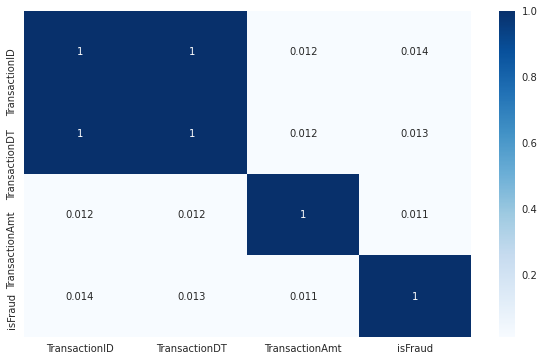

In [56]:
lst1 = ['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'isFraud']

corr1 = train[lst1].corr()
plt.subplots(figsize = (10, 6))
sns.heatmap(corr1, annot = True, cmap = "Blues")

<AxesSubplot:>

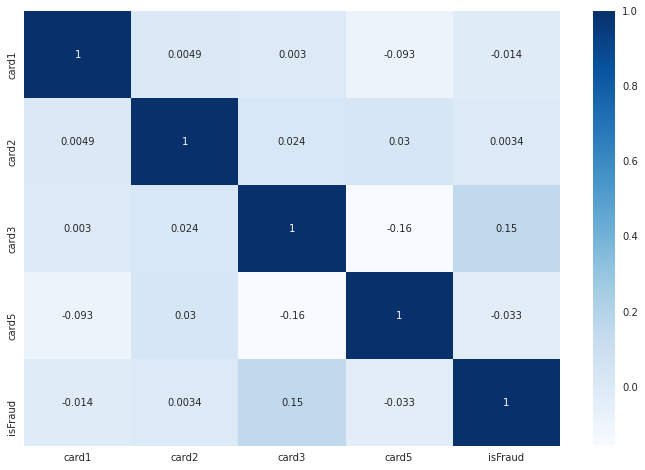

In [57]:
lst2 = ['card1', 'card2', 'card3', 'card5', 'isFraud']

corr2 = train[lst2].corr()
plt.subplots(figsize = (12, 8))
sns.heatmap(corr2, annot = True, cmap = "Blues")

<AxesSubplot:>

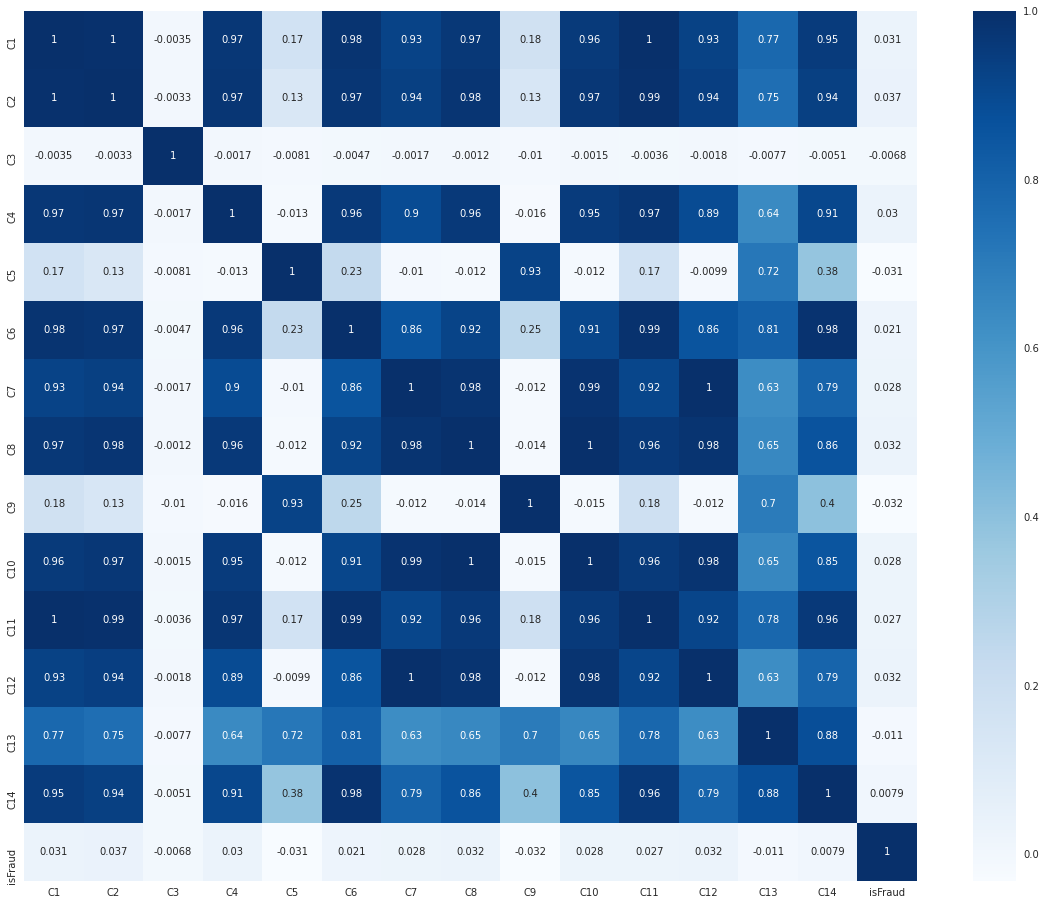

In [58]:
lst3 = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'isFraud']

corr3 = train[lst3].corr()
plt.subplots(figsize = (20, 16))
sns.heatmap(corr3, annot = True, cmap = "Blues")

<AxesSubplot:>

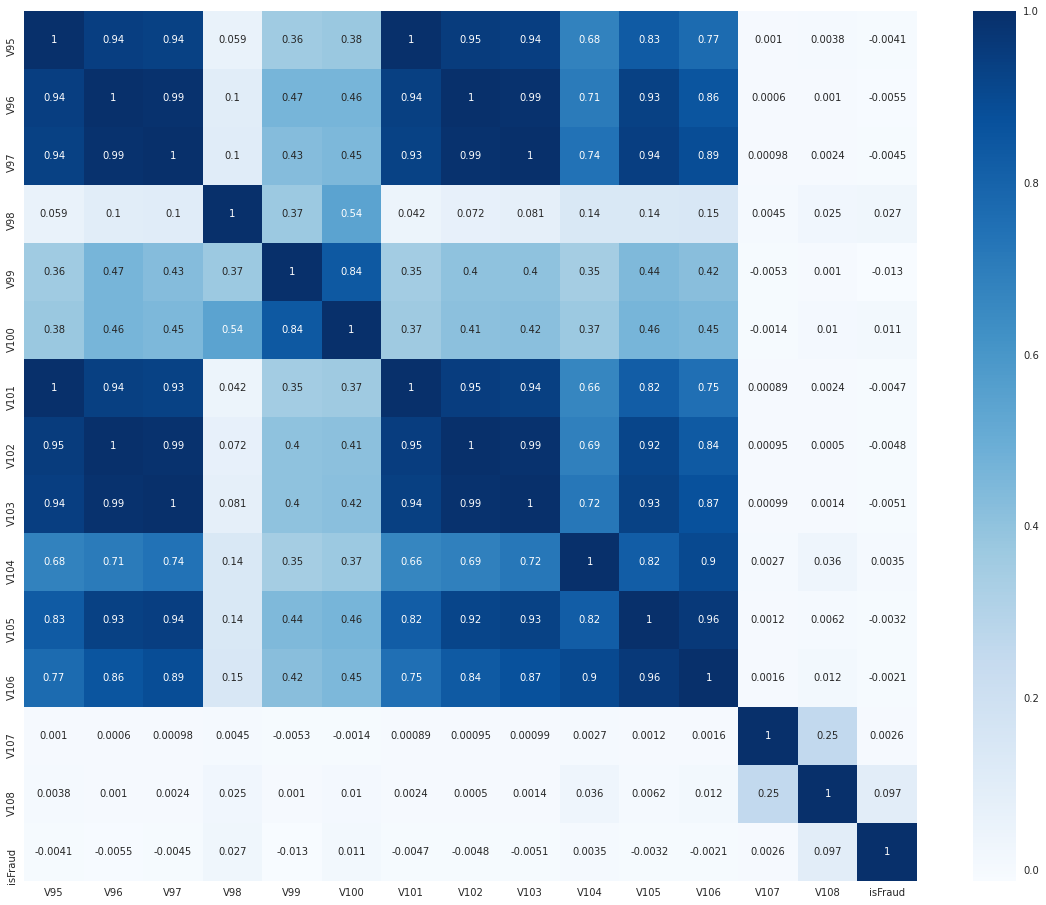

In [59]:
lst4 = ['V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'isFraud']

corr4 = train[lst4].corr()
plt.subplots(figsize = (20, 16))
sns.heatmap(corr4, annot = True, cmap = "Blues")

<AxesSubplot:>

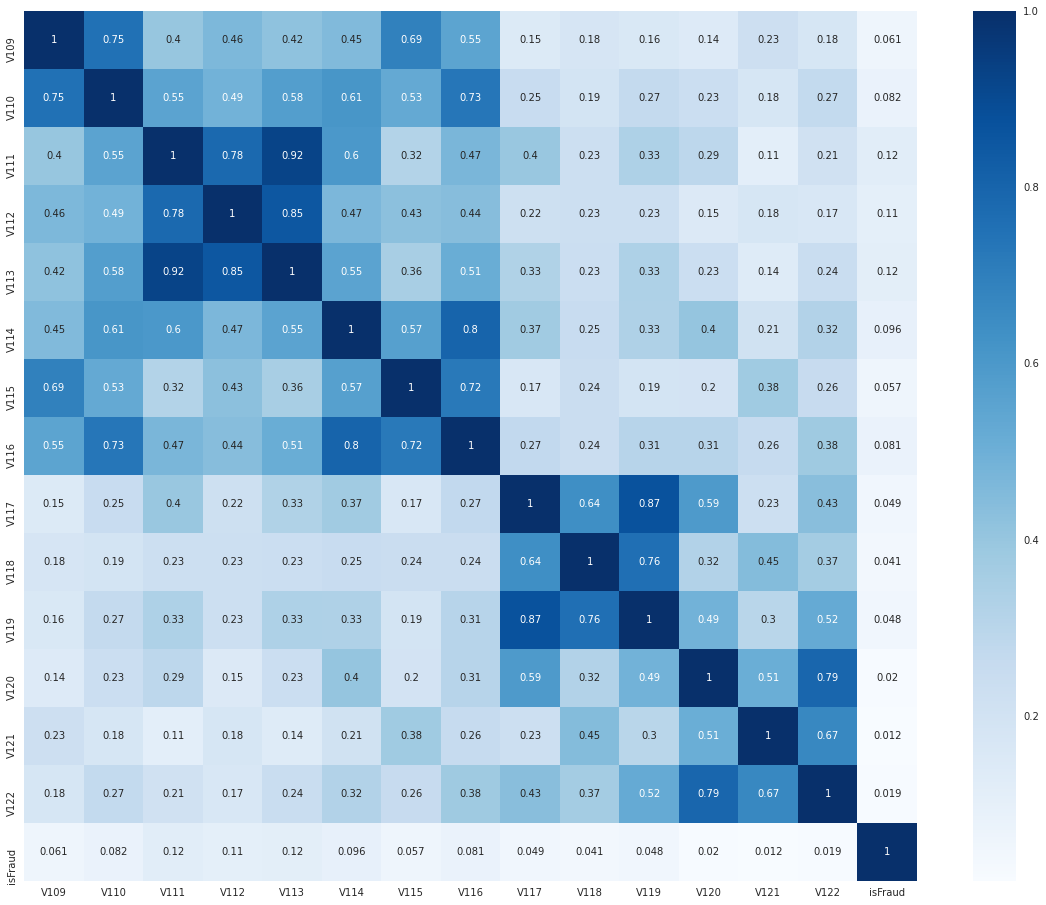

In [60]:
lst5 = ['V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'isFraud']

corr5 = train[lst5].corr()
plt.subplots(figsize = (20, 16))
sns.heatmap(corr5, annot = True, cmap = "Blues")

<AxesSubplot:>

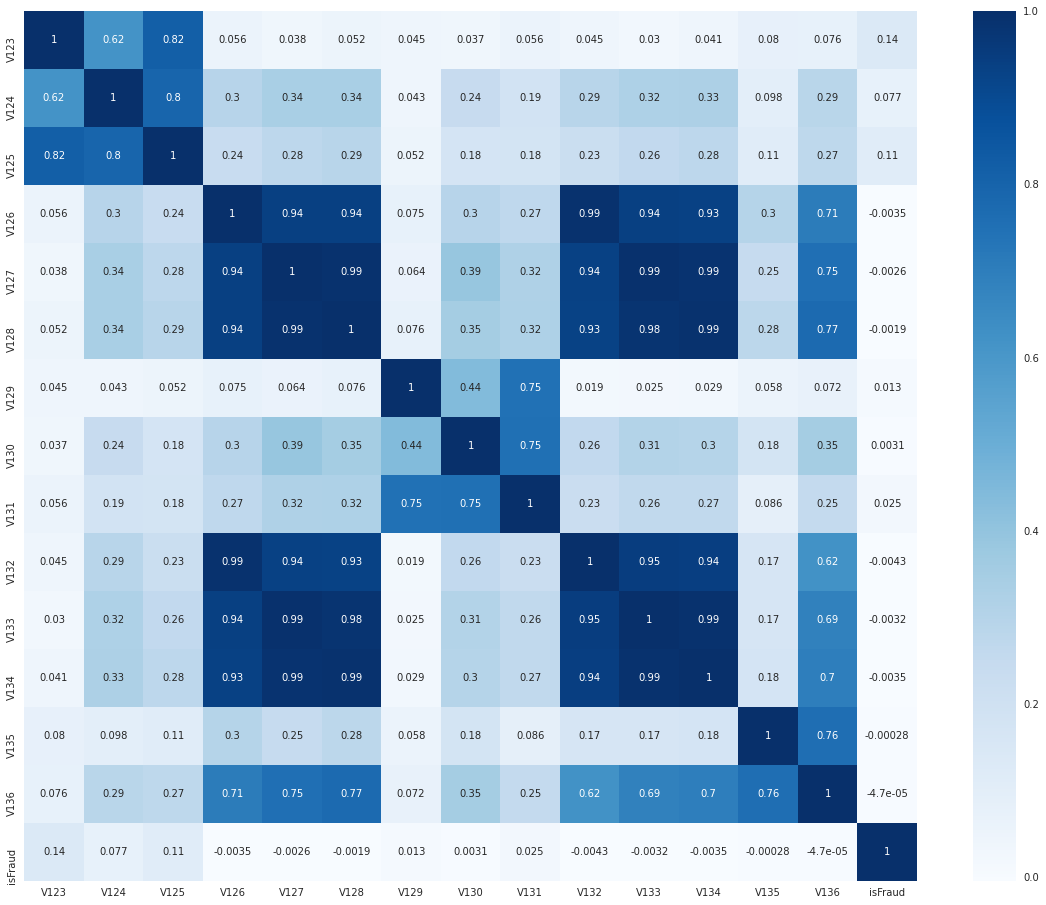

In [61]:
lst6 = ['V123', 'V124', 'V125', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132', 'V133', 'V134', 'V135', 'V136', 'isFraud']

corr6 = train[lst6].corr()
plt.subplots(figsize = (20, 16))
sns.heatmap(corr6, annot = True, cmap = "Blues")

<AxesSubplot:>

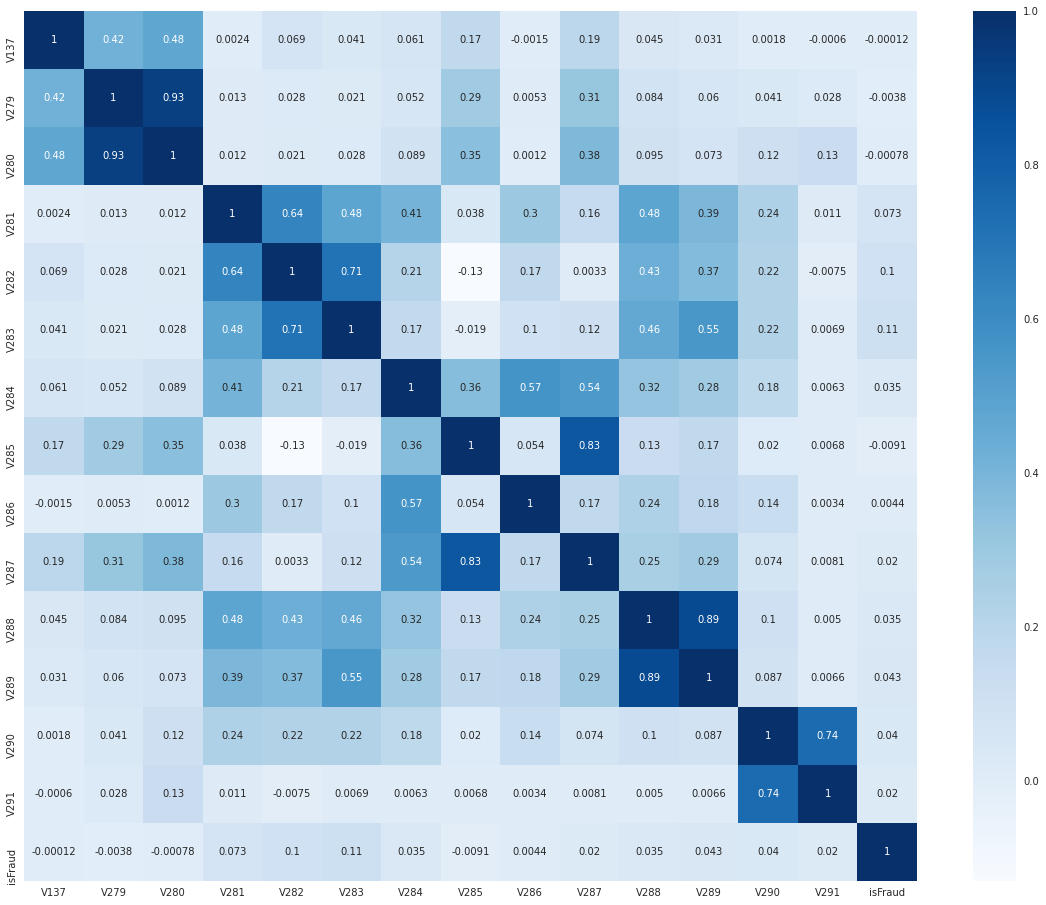

In [62]:
lst7 = ['V137', 'V279', 'V280', 'V281', 'V282', 'V283', 'V284', 'V285', 'V286', 'V287', 'V288', 'V289', 'V290', 'V291', 'isFraud']

corr7 = train[lst7].corr()
plt.subplots(figsize = (20, 16))
sns.heatmap(corr7, annot = True, cmap = "Blues")

<AxesSubplot:>

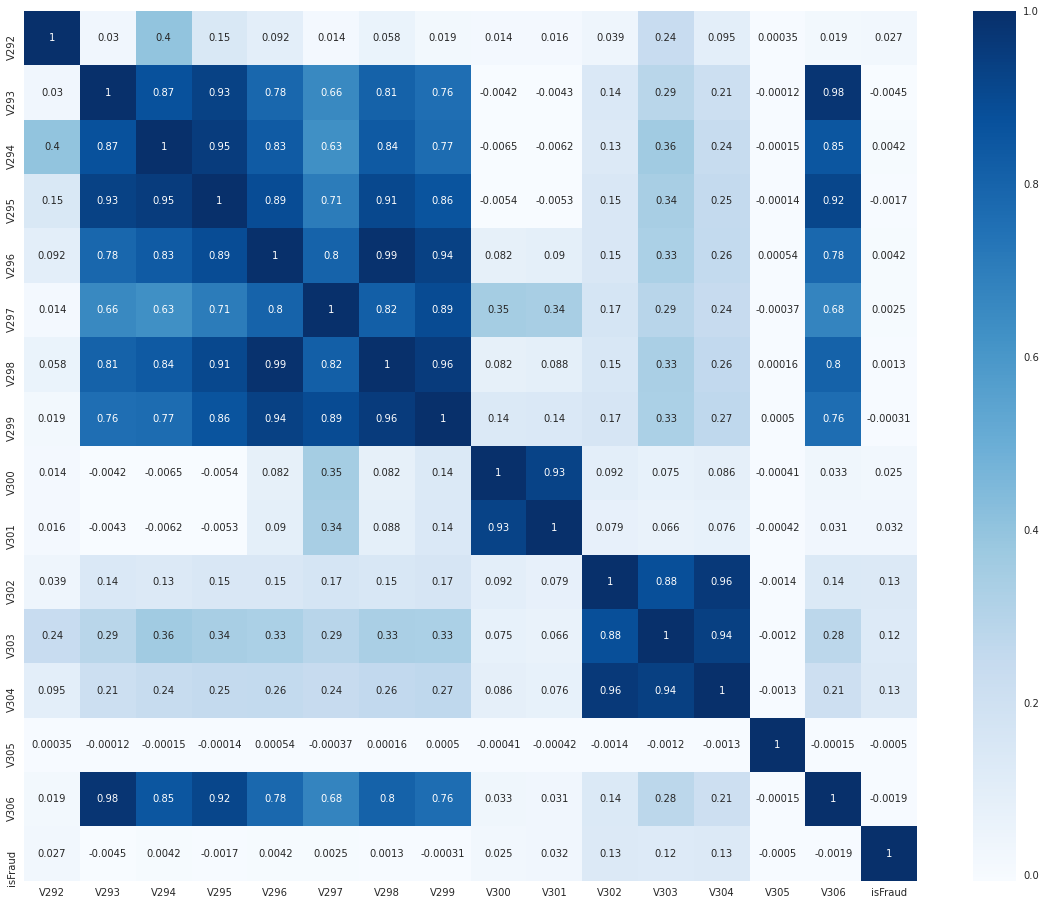

In [63]:
lst8 = ['V292', 'V293', 'V294', 'V295', 'V296', 'V297', 'V298', 'V299', 'V300', 'V301', 'V302', 'V303', 'V304', 'V305', 'V306', 'isFraud']

corr8 = train[lst8].corr()
plt.subplots(figsize = (20, 16))
sns.heatmap(corr8, annot = True, cmap = "Blues")

<AxesSubplot:>

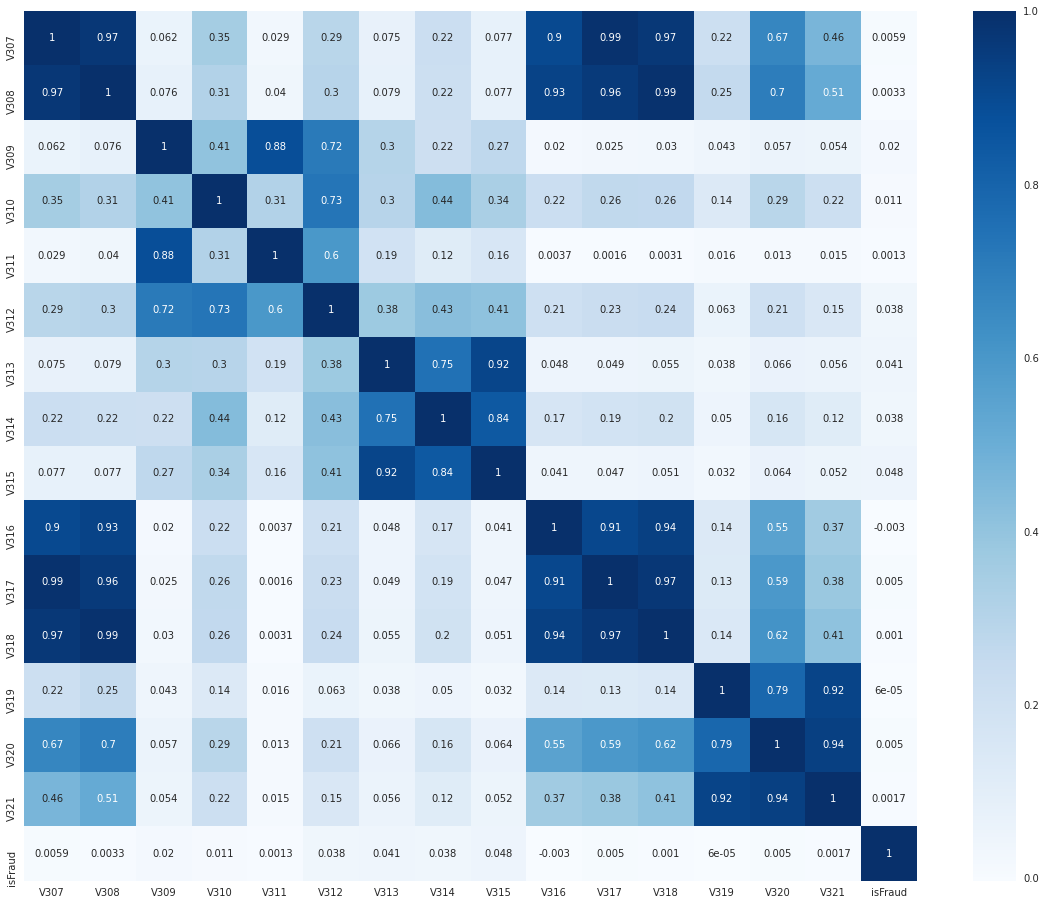

In [64]:
lst9 = ['V307', 'V308', 'V309', 'V310', 'V311', 'V312', 'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320', 'V321', 'isFraud']

corr9 = train[lst9].corr()
plt.subplots(figsize = (20, 16))
sns.heatmap(corr9, annot = True, cmap = "Blues")

### **Encode the categorical features**

In [65]:
ntrain = train.shape[0]
ntest = test.shape[0]
all_data = pd.concat([train, test], axis = 0, sort = False)
print(all_data.shape)

(1097231, 112)


In [66]:
ntrain + ntest

1097231

In [67]:
# Encoding the data

all_data = pd.get_dummies(all_data)
print(all_data.shape)
all_data.head()

(1097231, 122)


,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W,card4_american express,card4_discover,card4_mastercard,card4_visa,card6_charge card,card6_credit,card6_debit,card6_debit or credit
0,2987000,0.0,86400,68.5,13926,363.099769,150.0,142.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,1,0,0,0,1,0,0
1,2987001,0.0,86401,29.0,2755,404.000000,150.0,102.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,1,0,0,1,0,0
2,2987002,0.0,86469,59.0,4663,490.000000,150.0,166.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,1,0,0,1,0
3,2987003,0.0,86499,50.0,18132,567.000000,150.0,117.0,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,1.0,48.0,28.0,0.0,10.0,4.0,1.0,38.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,50.0,1758.0,925.0,0.0,354.0,135.0,50.0,1404.0,790.0,0.0,0.0,0.0,1.0,28.0,0.0,0.0,0.0,0.0,10.0,0.0,4.0,0.0,0.0,1.0,1.0,1.0,1.0,38.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,0,0,0,0,1,0,0,1,0,0,0,1,0
4,2987004,0.0,86506,50.0,4497,514.000000,150.0,102.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,1,0,0,1,0,0


In [68]:
# Split the data again and get ready for training

train = all_data[:ntrain]
test = all_data[ntrain:]

In [69]:
train.drop(['TransactionDT'], axis = 1, inplace = True)

test.drop(['TransactionDT'], axis = 1, inplace = True)

print(train.shape)
print(test.shape)

(590540, 121)
(506691, 121)


In [70]:
train.head()

,TransactionID,isFraud,TransactionAmt,card1,card2,card3,card5,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W,card4_american express,card4_discover,card4_mastercard,card4_visa,card6_charge card,card6_credit,card6_debit,card6_debit or credit
0,2987000,0.0,68.5,13926,363.099769,150.0,142.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,1,0,0,0,1,0,0
1,2987001,0.0,29.0,2755,404.000000,150.0,102.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,1,0,0,1,0,0
2,2987002,0.0,59.0,4663,490.000000,150.0,166.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,1,0,0,1,0
3,2987003,0.0,50.0,18132,567.000000,150.0,117.0,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,1.0,48.0,28.0,0.0,10.0,4.0,1.0,38.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,50.0,1758.0,925.0,0.0,354.0,135.0,50.0,1404.0,790.0,0.0,0.0,0.0,1.0,28.0,0.0,0.0,0.0,0.0,10.0,0.0,4.0,0.0,0.0,1.0,1.0,1.0,1.0,38.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,0,0,0,0,1,0,0,1,0,0,0,1,0
4,2987004,0.0,50.0,4497,514.000000,150.0,102.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,1,0,0,1,0,0


In [71]:
test.head()

,TransactionID,isFraud,TransactionAmt,card1,card2,card3,card5,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W,card4_american express,card4_discover,card4_mastercard,card4_visa,card6_charge card,card6_credit,card6_debit,card6_debit or credit
0,3663549,NaN,31.95,10409,111.0,150.0,226.0,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,1,0,0,1,0
1,3663550,NaN,49.00,4272,111.0,150.0,226.0,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,0.0,4.0,1.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,280.000000,77.000000,0.000000,280.000000,77.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,280.000000,77.000000,0.000000,280.000000,0.000000,77.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,1,0,0,1,0
2,3663551,NaN,171.00,4476,574.0,150.0,226.0,2.0,2.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,2.0,0.0,22.0,2.0,137.0,0.0,5.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,968.000000,0.000000,0.000000,705.000000,0.000000,0.0,0.0,0.0,0.0,263.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,1321.000000,0.000000,0.000000,1058.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,263.0,0.0,0,0,0,0,1,0,0,0,1,0,0,1,0
3,3663552,NaN,284.95,10989,360.0,150.0,166.0,5.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,7.0,4.0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,282.540009,282.540009,282.540009,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,1,0,0,1,0
4,3663553,NaN,67.95,18018,452.0,150.0,117.0,6.0,6.0,0.0,0.0,2.0,5.0,0.0,0.0,5.0,0.0,6.0,0.0,14.0,6.0,22.0,1.0,3.0,1.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,67.949997,183.850006,67.949997,67.949997,183.850006,67.949997,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,67.949997,183.850006,67.949997,67.949997,183.850006,67.949997,67.949997,67.949997,183.850006,67.949997,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,1,0,0,0,1,0


In [72]:
target

0         0
1         0
2         0
3         0
4         0
         ..
590535    0
590536    0
590537    0
590538    0
590539    0
Name: isFraud, Length: 590540, dtype: int64

In [73]:
different_columns(train.columns, test.columns)

In [74]:
train.drop(['isFraud'], axis = 1, inplace = True)
test.drop(['isFraud'], axis = 1, inplace = True)

print(train.shape)
print(test.shape)

(590540, 120)
(506691, 120)


## **Model Building**

### **XGBoost**

In [75]:
xgmodel = xgb.XGBClassifier(colsample_bytree = 0.4,
                            subsample = 0.8,
                            learning_rate = 0.03, 
                            max_depth = 30, 
                            n_estimators = 3000,
                            random_state = 42, 
                            nthread = -1)
xgmodel.fit(train, target)

[08:16:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.03, max_delta_step=0, max_depth=30,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=3000, n_jobs=4, nthread=-1, num_parallel_tree=1,
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.8, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [76]:
y_pred = xgmodel.predict_proba(test)

In [77]:
print(y_pred)

[[9.9995279e-01 4.7231129e-05]
 [9.9993473e-01 6.5243083e-05]
 [9.9948376e-01 5.1624328e-04]
 ...
 [9.9979192e-01 2.0810640e-04]
 [9.9991053e-01 8.9484231e-05]
 [9.9996197e-01 3.8035472e-05]]


In [80]:
test_id = test['TransactionID']

sub = pd.DataFrame()
sub['TransactionID'] = test_id
sub['isFraud'] = y_pred[:, 1]
sub.to_csv('submission_xgb_2.csv', index = False)